<a href="https://colab.research.google.com/github/Pakopac/Monkey_Species_CNN/blob/master/MonkeySpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monkey Species Recognition CNN

Welcome in this notebook of the project ML recognition monkey species. \
Here we will describe step by step how to build a CNN model to a make a prediction of a specie of monkey from an image. \

## Setup

First we need to import the librairies needed. 

In [37]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import h5py
import pandas as pd
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Data Visualization
from matplotlib import pyplot as plt

In [38]:
# GPU mode for colab notebook
from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"

I'm importing datas from my drive, I got the datas here: https://www.kaggle.com/slothkong/10-monkey-species

In [39]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab_Notebooks/monkey/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Arrays with labels, types and some test images

In [ ]:
test_labels = ["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
test_images = [
    "https://projectzerofootprint.com/wp-content/uploads/2016/08/monkey-2-1080x768.jpg",
    "https://i.ytimg.com/vi/Ptisy32iRRA/hqdefault.jpg",
    "https://images.pond5.com/red-uakari-monkey-footage-064800523_iconl.jpeg",
    "https://thejapanalps.com/wp-content/uploads/2020/03/nihonsaru01.jpg",
    "https://www.zoo-leipzig.de/fileadmin/_processed_/e/c/csm_Weissbauch-Zwergseidenaeffchen_3_c46c37b6a1.jpg",
    "https://cdn.britannica.com/05/181805-050-C9682415/capuchin-monkey.jpg",
    "https://www.neprimateconservancy.org/uploads/1/5/3/8/15380094/silvery-marmoset-istock-153473655-resize_45.jpg",
    "https://study.com/cimages/multimages/16/squirrel_monkeys.png",
    "https://ars.els-cdn.com/content/image/3-s2.0-B9780124095274000171-f17-04-9780124095274.jpg",
    "https://media-cdn.tripadvisor.com/media/photo-s/0a/67/93/f5/nilgiri-langur-karunkorangu.jpg"
]
monkey_species_type = ["Mantled Howler","Patas Monkey","Bald Uakari",
                        "Japanese Macaque","Pygmy Marmoset","White Headed Capuchin",
                        "Silvery Marmoset","Ommon Squirrel Monkey",
                        "Black Headed Night Monkey","Nilgiri Langur"]

Define hyperparameters here.

In [40]:
# Number trained/test images for model
N_train = 200
N_val = 80
# Image size for model
img_width = 150
img_height = 150
# Number of time iterate
epochs = 10
batch_size = 4

Informations per species are listed in monkey_labels.txt with the label, the names, the number of train images and the number of validations images

## EDA / Preprocessing

In [5]:
# We define columns and display as a pandas dataframe
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
df = pd.read_csv(data_dir + "monkey_labels.txt", names=cols, skiprows=1)
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


We can check the proportion of images of each species as a diagram. \
We have about the same values, in train we have between 130 and 150 images of each and in test we have between 25 and 30 images

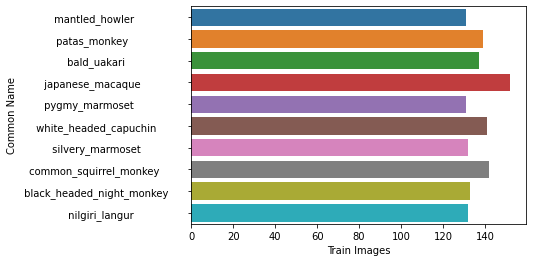

In [6]:
sns.barplot(x = df["Train Images"], y = df["Common Name"])
plt.show()

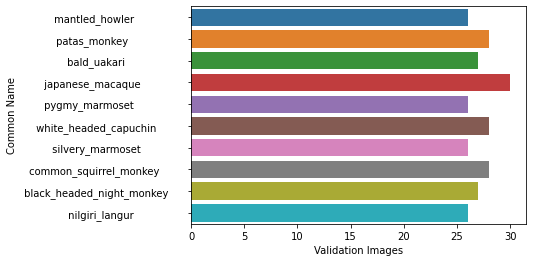

In [7]:
sns.barplot(x = df["Validation Images"], y = df["Common Name"])
plt.show()

We can load an image with kpi.load_image and convert to an array to test the render of image

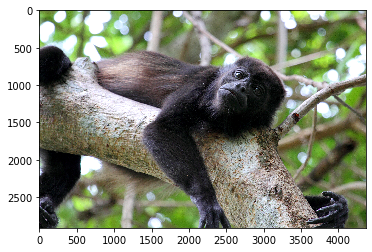

In [8]:
img = kpi.load_img(data_dir+'training/training/n0/n0021.jpg')
# Convert as array to show with pyplot
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

Display one image of each

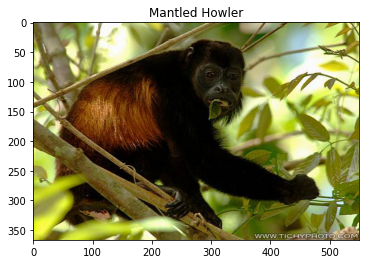

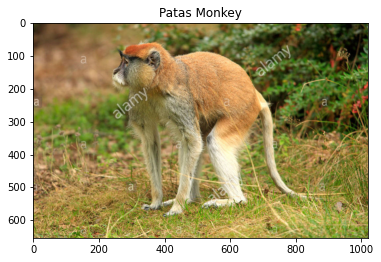

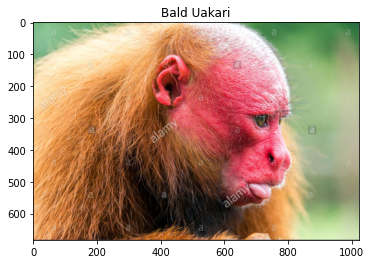

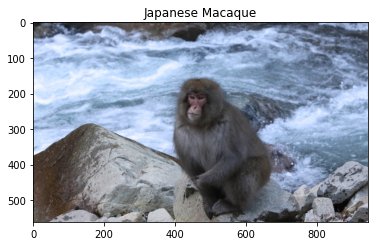

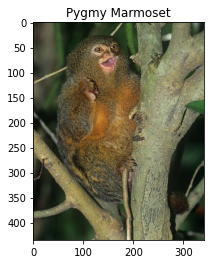

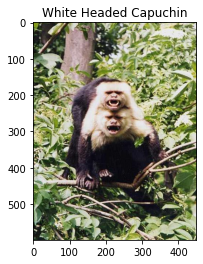

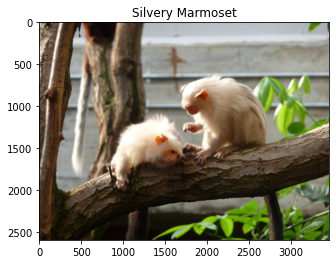

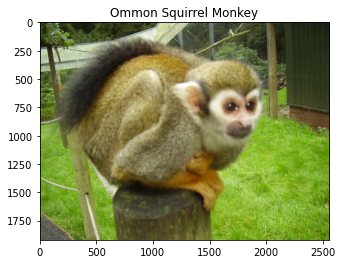

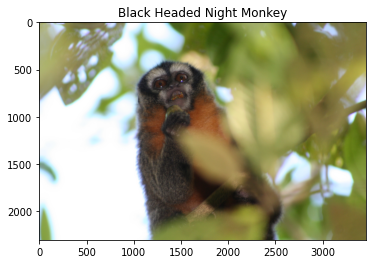

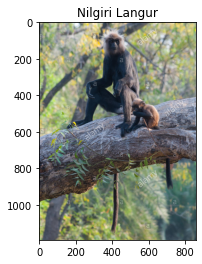

In [26]:
# Get first image of each directory in training and display with pyplot
for (i,label) in enumerate(test_labels):
  response = data_dir + "training/training/" + label +  "/" + os.listdir(data_dir + "training/training/" + label)[0]
  img = Image.open(response)
  image = tf.keras.utils.img_to_array(img.resize((224, 224)))
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  plt.title(monkey_speciets_type[i])
  plt.imshow(img)
  plt.show()

## Model

Define train and test generator for model

In [44]:
# data augmentation on train (zoom, rotate, rescale...)
train_datagen = kpi.ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir + 'training/training',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    data_dir + 'validation/validation',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

Found 895 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Define model

In [45]:
# Using pre-trained model resnet50
model_base = ka.resnet_v2.ResNet50V2(weights='imagenet',include_top=False)

x = model_base.output
x = kl.GlobalAveragePooling2D()(x)
x = kl.Dense(512,activation='relu')(x)
# Set 10 classes
predictions = kl.Dense(10 ,activation='softmax')(x)
Resnet50_model = km.Model(inputs= model_base.input, outputs=predictions)

Model fit

In [51]:
# Compile with categorical argument
Resnet50_model.compile(loss='categorical_crossentropy' ,metrics=['accuracy'])
# fit with 30 epoch for good accuracy
history = Resnet50_model.fit_generator(train_generator, epochs=30, shuffle=False, verbose=1, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
224/224 [==============================] - 60s 221ms/step - loss: 1.4918 - accuracy: 0.4134 - val_loss: 2.9804 - val_accuracy: 0.3824
Epoch 2/30
224/224 [==============================] - 54s 241ms/step - loss: 1.4580 - accuracy: 0.4402 - val_loss: 2.8349 - val_accuracy: 0.4191
Epoch 3/30
224/224 [==============================] - 47s 210ms/step - loss: 1.4208 - accuracy: 0.4883 - val_loss: 2.7587 - val_accuracy: 0.3346
Epoch 4/30
224/224 [==============================] - 47s 212ms/step - loss: 1.4050 - accuracy: 0.4883 - val_loss: 3.0527 - val_accuracy: 0.3566
Epoch 5/30
224/224 [==============================] - 47s 211ms/step - loss: 1.3170 - accuracy: 0.5050 - val_loss: 4.4240 - val_accuracy: 0.2574
Epoch 6/30
224/224 [==============================] - 55s 247ms/step - loss: 1.3441 - accuracy: 0.5173 - val_loss: 2.9319 - val_accuracy: 0.3676
Epoch 7/30
224/224 [==============================] - 60s 265ms/step - loss: 1.2557 - accuracy: 0.5408 - val_loss: 2.4478 - val_ac

In [53]:
# Function for plot accuracy/loss
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()
    plt.show()

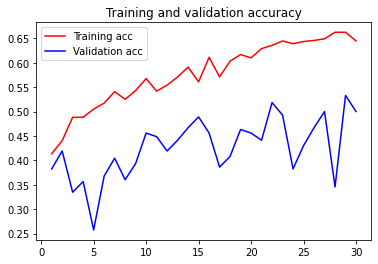

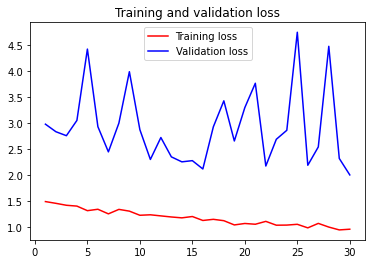

In [54]:
# 1- history training/validation accuracy over the epochs
# 2- history training/validation loss over the epochs
history_plot(history)

Save model

In [55]:
Resnet50_model.save(data_dir + "model_res50.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [56]:
loses=pd.DataFrame(Resnet50_model.history.history)
loses

,loss,accuracy,val_loss,val_accuracy
0,1.491785,0.413408,2.980408,0.382353
1,1.458023,0.440223,2.834896,0.419118
2,1.420812,0.488268,2.758722,0.334559
3,1.404991,0.488268,3.052657,0.356618
4,1.316968,0.505028,4.424048,0.257353
5,1.344110,0.517318,2.931863,0.367647
6,1.255743,0.540782,2.447818,0.404412
7,1.341724,0.525140,3.000240,0.360294
8,1.308004,0.543017,3.989346,0.393382
9,1.228626,0.567598,2.874182,0.455882


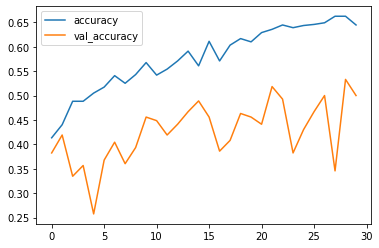

In [57]:
loses[['accuracy','val_accuracy']].plot()

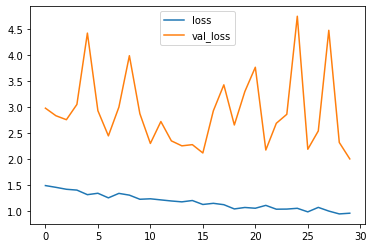

In [58]:
loses[['loss','val_loss']].plot()

## Predictions

Get predictions with tests images: predict/real 

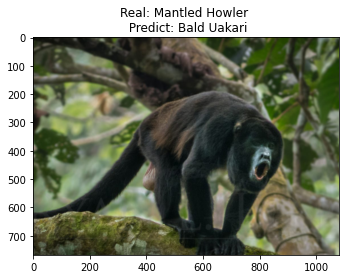

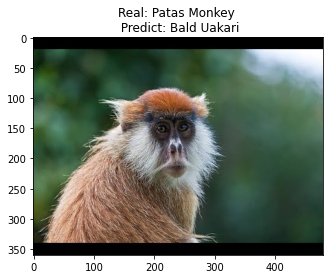

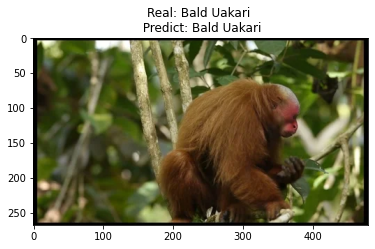

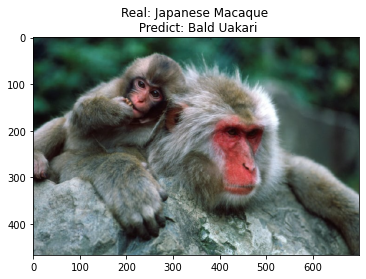

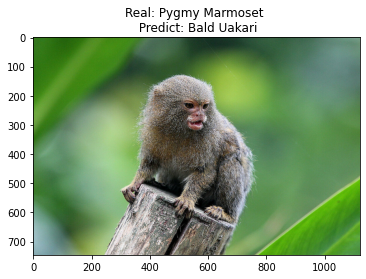

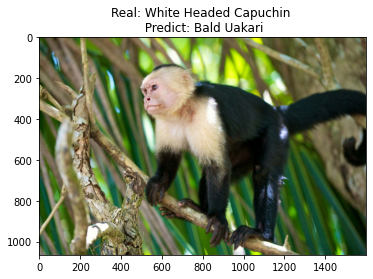

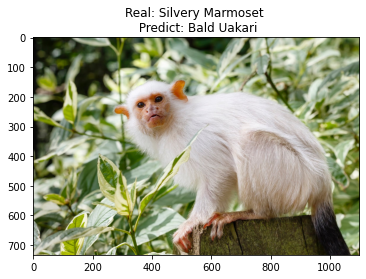

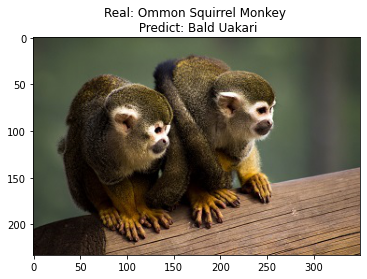

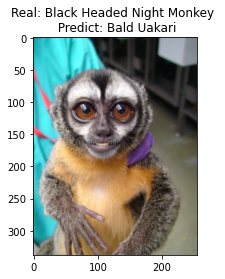

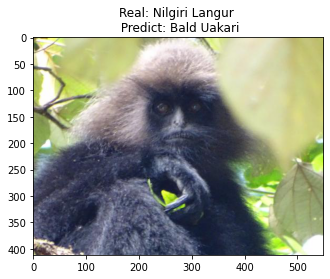

In [59]:
import io
import requests
from PIL import Image

for (i,label) in enumerate(test_labels):
    # img = load_img(img_name,target_size=(224,224))
    response = requests.get(test_images[i])
    img = Image.open(io.BytesIO(response.content))
    image = tf.keras.utils.img_to_array(img.resize((224, 224)))
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    prediction=Resnet50_model.predict(image)
    output = np.argmax(prediction)
        
    plt.title("Real: {} \n Predict: {}".format(monkey_speciets_type[i], monkey_speciets_type[output]))
    plt.imshow(img)
    plt.show()